In [138]:
import numpy as np
import pandas as pd
import seaborn as sns
import time
from scipy.stats import chi2_contingency

import sklearn
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectFromModel,SelectKBest, f_classif, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import svm

import matplotlib.pyplot as plt
%matplotlib inline

# Formatting

In [109]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = "\\usepackage{subdepth} \\usepackage{type1cm}"

# Data Import

In [140]:
b_df = pd.read_csv("data/matrix_bronchial.csv", index_col = 0)
n_df = pd.read_csv("data/matrix_nasal.csv", index_col = 0)

In [112]:
b_df.head()

cancer   7892501   7892502   7892503    7892504   7892505  \
geoid                                                                   
GSM1623452       0  4.216093  5.842999  4.980203  10.059506  5.019846   
GSM1623453       0  4.477295  5.527915  5.125640  10.467440  5.182849   
GSM1623454       1  4.192968  5.609544  4.603893  10.565574  4.886351   
GSM1623455       1  3.857432  5.239925  4.875725  10.213407  4.475636   
GSM1623456       1  4.179410  4.913780  4.688398  10.426099  5.461521   

             7892506   7892507   7892508    7892509    ...       8180409  \
geoid                                                  ...                 
GSM1623452  6.643097  6.017031  7.155189  10.788140    ...     10.194038   
GSM1623453  6.045693  6.547059  8.011207  10.814677    ...     10.524005   
GSM1623454  5.849225  6.652074  8.215739  10.908662    ...     10.353227   
GSM1623455  5.498195  7.000071  7.021440  10.936842    ...     10.227046   
GSM1623456  5.458753  6.344151  6.901630  10.813660    ...     10.198178   

              8180410   8180411   8180412   8180413    8180414   8180415  \
geoid                                                                      
GSM1623452  10.516945  7.357735  8.375515  8.307193  10.754339  7.411120   
GSM1623453  10.533004  7.381779  8.307119  8.211558  10.586939  7.437256   
GSM1623454  10.693120  7.223452  8.467328  8.398528  10.904259  7.763389   
GSM1623455  10.476882  7.238507  8.365352  8.294859  11.067606  7.176992   
GSM1623456  10.340738  7.295370  8.304812  8.318317  10.599784  7.251437   

             8180416   8180417   8180418  
geoid                                     
GSM1623452  6.186312  8.777097  9.784806  
GSM1623453  6.320433  8.776844  9.862342  
GSM1623454  6.184391  9.064446  9.734410  
GSM1623455  6.300595  8.884312  9.684322  
GSM1623456  6.336659  8.934200  9.608108  

[5 rows x 33298 columns]

In [237]:
train_df, test_df = sklearn.model_selection.train_test_split(b_df, test_size = 0.3, random_state = 12345)

In [238]:
(train_df.shape[0], test_df.shape[0])

(476, 204)

# PCA

Running PCA and basic visualization on the training set alone. Performed mean/variance standardization before feeding into the sklearn PCA algorithm.

In [152]:
# Pull Data
X_train = train_df.iloc[:,1:].values
y_train = train_df.iloc[:,0].values
X_test = test_df.iloc[:,1:].values
y_test = test_df.iloc[:,0].values

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

## 2 Component

In [153]:
k = 2

pca = PCA(n_components = k)
pca_fit = pca.fit_transform(X_train)

print("Explained variance: {}".format(pca.explained_variance_ratio_))

Explained variance: [0.25880918 0.15160893]


In [154]:
pca_df = pd.DataFrame(data = pca_fit, columns = ['pc1', 'pc2'], index = train_df.index)
pca_df = pd.concat([train_df["cancer"], pca_df], axis = 1)

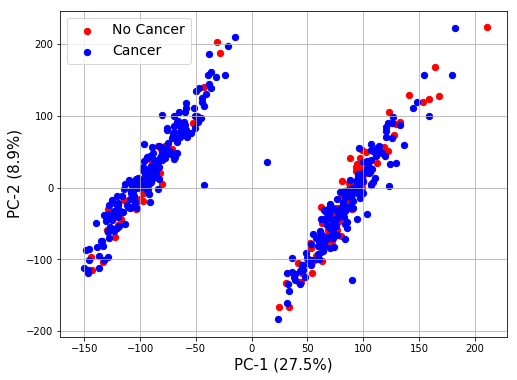

In [155]:
fig = plt.figure(figsize = (8,6))


ax = fig.add_subplot(1,1,1) 
ax.set_xlabel("PC-1 (27.5%)", fontsize = 15)
ax.set_ylabel("PC-2 (8.9%)", fontsize = 15)

colors = ['r', 'b']
targets = [0, 1]

for target, color in zip(targets,colors):
    idx = pca_df['cancer'] == target
    ax.scatter(pca_df.loc[idx, 'pc1'], pca_df.loc[idx, 'pc2'], c = color, s = 40)
ax.legend(["No Cancer", "Cancer"])
ax.grid()

plt.savefig("images/pca_2comp.pdf")

## Variance Test

In [126]:
var = 0
k = 1

while var < 0.8:
    pca = PCA(n_components = k)
    pca_fit = pca.fit_transform(X_train)
    var = np.sum(pca.explained_variance_ratio_)
    
    print("Variance explained by k = {}: {}".format(k, var))
    
    k+=5

Variance explained by k = 1: 0.25880917699945843
Variance explained by k = 6: 0.5713527221179707
Variance explained by k = 11: 0.6384261100598924
Variance explained by k = 16: 0.6709847377543801
Variance explained by k = 21: 0.6920253908135229
Variance explained by k = 26: 0.7077499973431746
Variance explained by k = 31: 0.7205210647630245
Variance explained by k = 36: 0.7308861890313533
Variance explained by k = 41: 0.7399577242628522
Variance explained by k = 46: 0.7479238489465665
Variance explained by k = 51: 0.7544764262423829
Variance explained by k = 56: 0.760901998544012
Variance explained by k = 61: 0.7666216692909135
Variance explained by k = 66: 0.772055293788475
Variance explained by k = 71: 0.7771495043637179
Variance explained by k = 76: 0.7819911512763952
Variance explained by k = 81: 0.7868054183215436
Variance explained by k = 86: 0.7910817557291722
Variance explained by k = 91: 0.7952801621595975
Variance explained by k = 96: 0.7995780330350238
Variance explained by k

## Many Component

Seeing if a heatmap distinguishes between the classes when using all the features (gene probes) and running PCA to retain the majority of the samle variance.

It looks like the cancer = 1 samples are "lighter" on the PCA heatmap, but it isnt a very telling disguisher. I feel like feature selection on the initial gene probes could be very beneficial for this, so we can possibly use less PCA components to better distinguish the classes when we look at the proper genes subset from the get-go?

In [135]:
k = 100

pca_train = PCA(n_components = k)
X_train_pca = pca_train.fit_transform(X_train)
X_test_pca = pca_train.transform(X_test)

print("Explained variance: {}".format(np.sum(pca_train.explained_variance_ratio_)))

Explained variance: 0.8028655756490198


In [128]:
pca_df = pd.DataFrame(data = train_pca_map, index = train_df.index)
pca_df = pd.concat([train_df["cancer"], pca_df], axis = 1)

In [129]:
pca0 = pca_df[pca_df["cancer"] == 0].values[:,1:]
pca1 = pca_df[pca_df["cancer"] == 1].values[:,1:]

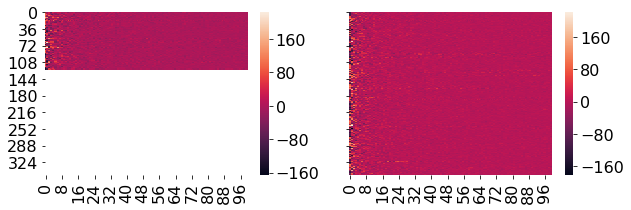

In [130]:
fig, ax = plt.subplots(1, 2, figsize=(10,3), sharey = True) 

sns.heatmap(pca0, ax = ax[0])
sns.heatmap(pca1, ax = ax[1])

plt.show()

In [136]:
LR = LogisticRegression(solver="newton-cg")
LR.fit(X_train_pca, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [137]:
y_train_pred = LR.predict(X_train_pca) 
train_mat = sklearn.metrics.confusion_matrix(y_train, y_train_pred).ravel()

y_test_pred = LR.predict(X_test_pca)
test_mat = sklearn.metrics.confusion_matrix(y_test, y_test_pred).ravel()
(train_mat, test_mat)

(array([ 86,  37,  15, 338]), array([ 25,  42,   5, 132]))

# Initial Model Selection

Basic model exploration for LR, SVM, and RF classifiers. No fine details are tuned in this section.

In [239]:
# Pull Data
X_train = train_df.iloc[:,1:].values
y_train = train_df.iloc[:,0].values
X_test = test_df.iloc[:,1:].values
y_test = test_df.iloc[:,0].values

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

## Logistic Regression

In [234]:
LR = LogisticRegression(solver = "newton-cg")

LR.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [235]:
y_train_pred = LR.predict(X_train) 
train_mat = sklearn.metrics.confusion_matrix(y_train, y_train_pred).ravel()

y_test_pred = LR.predict(X_test)
test_mat = sklearn.metrics.confusion_matrix(y_test, y_test_pred).ravel()
(train_mat, test_mat)

(array([142,   0,   0, 211]), array([15, 39, 27, 71]))

In [236]:
scores = cross_val_score(LR, X_train, y_train, cv = 5, scoring = "accuracy")

print("Mean CV Accuracy: {}".format(np.mean(scores)))

Mean CV Accuracy: 0.6232707355242566


## SVM

### Linear Kernel

In [160]:
svl = svm.SVC(C = 2, gamma = "auto", kernel = "linear")

svl.fit(X_train, y_train)

SVC(C=2, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [161]:
y_train_pred = svl.predict(X_train) 
train_mat = sklearn.metrics.confusion_matrix(y_train, y_train_pred).ravel()

y_test_pred = svl.predict(X_test)
test_mat = sklearn.metrics.confusion_matrix(y_test, y_test_pred).ravel()
(train_mat, test_mat)

(array([123,   0,   0, 353]), array([ 27,  40,   6, 131]))

In [162]:
scores = cross_val_score(svl, X_train, y_train, cv = 5)

print("Mean CV Accuracy: {}".format(np.mean(scores)))

Mean CV Accuracy: 0.7772606382978724


### RBF Kernel

In [165]:
svr = svm.SVC(C = 2, gamma = "auto", kernel = "rbf")

svr.fit(X_train, y_train)

SVC(C=2, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [166]:
y_train_pred = svr.predict(X_train) 
train_mat = sklearn.metrics.confusion_matrix(y_train, y_train_pred).ravel()

y_test_pred = svr.predict(X_test)
test_mat = sklearn.metrics.confusion_matrix(y_test, y_test_pred).ravel()
(train_mat, test_mat)

(array([119,   4,   0, 353]), array([  7,  60,   1, 136]))

In [167]:
scores = cross_val_score(svr, X_train, y_train, cv = 5, scoring = "accuracy")

print("Mean CV Accuracy: {}".format(np.mean(scores)))

Mean CV Accuracy: 0.7647606382978723


## Random Forest

In [168]:
rfc = RandomForestClassifier(random_state = 12345, n_estimators = 100)

rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=12345, verbose=0,
            warm_start=False)

In [169]:
y_train_pred = rfc.predict(X_train) 
train_mat = sklearn.metrics.confusion_matrix(y_train, y_train_pred).ravel()

y_test_pred = rfc.predict(X_test) 
test_mat = sklearn.metrics.confusion_matrix(y_test, y_test_pred).ravel()
(train_mat, test_mat)

(array([123,   0,   0, 353]), array([  5,  62,   3, 134]))

In [471]:
scores = cross_val_score(rfc, X_train, y_train, cv = 5, scoring = "accuracy")

print("Mean CV Accuracy: {}".format(np.mean(scores)))

Mean CV Accuracy: 0.7462121212121213


# Feature Selection

In this section, we apply both Mutual Information and ANOVA based feature selections to try to optimize the feature subsets for a SVM and Random Forest classifier.

In [170]:
# Pull Data
X_train = train_df.iloc[:,1:].values
y_train = train_df.iloc[:,0].values
X_test = test_df.iloc[:,1:].values
y_test = test_df.iloc[:,0].values

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [171]:
mi = mutual_info_classif(X_train, y_train)

In [172]:
anova = f_classif(X_train, y_train)
fi = anova[0]
pi = anova[1]

## SVM

In [255]:
svr = svm.SVC(C = 3.5, gamma = "auto", kernel = "rbf")
svr.fit(X_train_sel, y_train)

# Predictions
y_train_pred = svr.predict(X_train_sel) 
train_mat = sklearn.metrics.confusion_matrix(y_train, y_train_pred).ravel()

y_test_pred = svr.predict(X_test_sel)
test_mat = sklearn.metrics.confusion_matrix(y_test, y_test_pred).ravel()
(train_mat, test_mat)

(array([123,   0,   0, 353]), array([ 21,  46,  11, 126]))

In [252]:
svl = svm.LinearSVC(C = 3.5)
svl.fit(X_train, y_train)

selector = SelectFromModel(svl, prefit = True, max_features = 250)
X_train_sel = selector.transform(X_train)

In [254]:
X_test_sel = selector.transform(X_test)

### Mutual Information

In [186]:
max_accuracy = 0
max_nf = 0
nf = 10

while nf <= 500:
    
    top_mi = np.argsort(-mi)[:nf]
    X_train_mi = X_train[:,top_mi]
    
    svr_mi = svm.SVC(C = 3.5, gamma = "auto", kernel = "rbf")
    scores = cross_val_score(svr_mi, X_train_mi, y_train, cv = 10, scoring = "accuracy")
    accuracy = np.mean(scores)
    
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        max_nf = nf
        print("# Features = {}, Mean CV Accuracy = {}".format(max_nf, max_accuracy))
        
    nf += 10

# Features = 10, Mean CV Accuracy = 0.7523230568823274
# Features = 30, Mean CV Accuracy = 0.7604863221884498
# Features = 40, Mean CV Accuracy = 0.7715588363004777
# Features = 90, Mean CV Accuracy = 0.7733391228831957
# Features = 100, Mean CV Accuracy = 0.7859313938341294
# Features = 110, Mean CV Accuracy = 0.7899261832392531
# Features = 120, Mean CV Accuracy = 0.7940946591402518
# Features = 180, Mean CV Accuracy = 0.7944420321320017
# Features = 190, Mean CV Accuracy = 0.7963091619626574
# Features = 210, Mean CV Accuracy = 0.8131567520625271
# Features = 220, Mean CV Accuracy = 0.8132435953104646


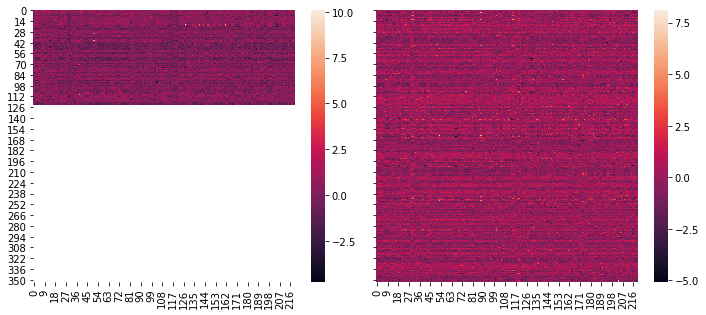

In [187]:
top_mi = np.argsort(-mi)[:max_nf]

mi_0 = X_train[y_train == 0][:,top_mi]
mi_1 = X_train[y_train == 1][:,top_mi]

fig, ax = plt.subplots(1, 2, figsize=(12,5), sharey = True) 
plt.subplots_adjust(wspace = 0.05)

sns.heatmap(mi_0, ax = ax[0])
sns.heatmap(mi_1, ax = ax[1])

plt.show()

In [189]:
# Using best MI features from CV test
top_mi = np.argsort(-mi)[:max_nf]

X_train_mi = X_train[:,top_mi]
X_test_mi = X_test[:,top_mi]

In [190]:
svr_mi = svm.SVC(C = 3.5, gamma = "auto", kernel = "rbf")
svr_mi.fit(X_train_mi, y_train)


# Predictions
y_train_pred = svr_mi.predict(X_train_mi) 
train_mat = sklearn.metrics.confusion_matrix(y_train, y_train_pred).ravel()

y_test_pred = svr_mi.predict(X_test_mi)
test_mat = sklearn.metrics.confusion_matrix(y_test, y_test_pred).ravel()
(train_mat, test_mat)

(array([123,   0,   1, 352]), array([ 29,  38,  13, 124]))

Visualize the optimally determined features using PCA to 2 dimensions:

In [191]:
k = 2

pca = PCA(n_components = k)
pca_fit = pca.fit_transform(X_train_mi)

pca_df = pd.DataFrame(data = pca_fit, columns = ['pc1', 'pc2'], index = train_df.index)
pca_df = pd.concat([train_df["cancer"], pca_df], axis = 1)

pca_var = pca.explained_variance_ratio_
print("Explained variance: {}".format(pca_var))

Explained variance: [0.32932904 0.10875717]


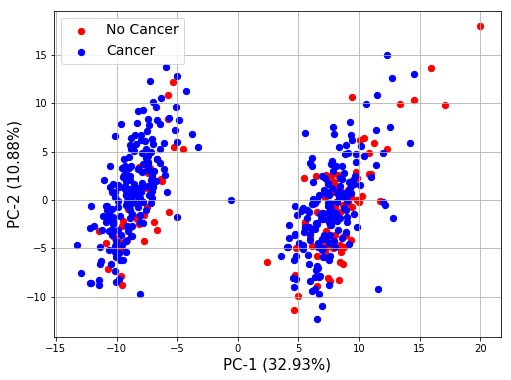

In [192]:
fig = plt.figure(figsize = (8,6))


ax = fig.add_subplot(1,1,1) 
ax.set_xlabel("PC-1 ({0:.2f}%)".format(pca_var[0]*100), fontsize = 15)
ax.set_ylabel("PC-2 ({0:.2f}%)".format(pca_var[1]*100), fontsize = 15)

colors = ['r', 'b']
targets = [0, 1]

for target, color in zip(targets,colors):
    idx = pca_df['cancer'] == target
    ax.scatter(pca_df.loc[idx, 'pc1'], pca_df.loc[idx, 'pc2'], c = color, s = 40)
ax.legend(["No Cancer", "Cancer"])
ax.grid()

### ANOVA

In [210]:
max_accuracy = 0
max_nf = 0
nf = 10

while nf <= 500:
    
    top_fi = np.argsort(-fi)[:nf]
    X_train_k = X_train[:,top_fi]
    
    svr_k = svm.SVC(C = 3.5, gamma = "auto", kernel = "rbf")
    scores = cross_val_score(svr_k, X_train_k, y_train, cv = 10, scoring = "accuracy")
    accuracy = np.mean(scores)
    
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        max_nf = nf
        print("# Features = {}, Mean CV Accuracy = {}".format(max_nf, max_accuracy))
        
    nf += 10

# Features = 10, Mean CV Accuracy = 0.7627008250108556
# Features = 60, Mean CV Accuracy = 0.7731654363873208
# Features = 90, Mean CV Accuracy = 0.7773339122883197
# Features = 100, Mean CV Accuracy = 0.7812418584455059
# Features = 110, Mean CV Accuracy = 0.7835432045158488
# Features = 120, Mean CV Accuracy = 0.802605297438124
# Features = 130, Mean CV Accuracy = 0.8026052974381243
# Features = 140, Mean CV Accuracy = 0.8045592705167174
# Features = 430, Mean CV Accuracy = 0.8049934867564046


In [215]:
selector = SelectKBest(f_classif, k = 100)

X_train_fi = selector.fit_transform(X_train, y_train)
X_test_fi = selector.transform(X_test)

In [216]:
y_train.shape

(476,)

In [217]:
svr_fi = svm.SVC(C = 3.5, gamma = "auto", kernel = "rbf")
svr_fi.fit(X_train_fi, y_train)


# Predictions
y_train_pred = svr_fi.predict(X_train_fi) 
train_mat = sklearn.metrics.confusion_matrix(y_train, y_train_pred).ravel()

y_test_pred = svr_fi.predict(X_test_fi)
test_mat = sklearn.metrics.confusion_matrix(y_test, y_test_pred).ravel()
(train_mat, test_mat)

(array([113,  10,   0, 353]), array([ 30,  37,  12, 125]))

Visualize the optimally determined features using PCA to 2 dimensions:

In [224]:
k = 2

pca = PCA(n_components = k)
pca_fit = pca.fit_transform(X_train_fi)

pca_df = pd.DataFrame(data = pca_fit, columns = ['pc1', 'pc2'], index = train_df.index)
pca_df = pd.concat([train_df["cancer"], pca_df], axis = 1)

pca_var = pca.explained_variance_ratio_
print("Explained variance: {}".format(pca_var))

Explained variance: [0.46295757 0.07095821]


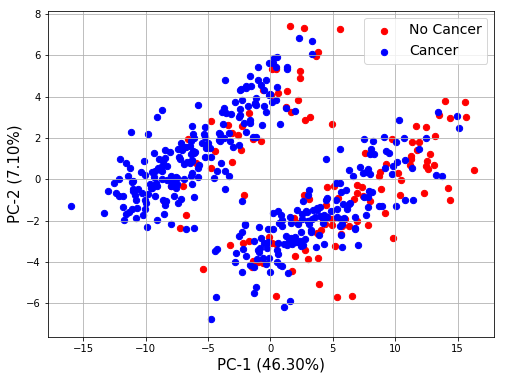

In [225]:
fig = plt.figure(figsize = (8,6))


ax = fig.add_subplot(1,1,1) 
ax.set_xlabel("PC-1 ({0:.2f}%)".format(pca_var[0]*100), fontsize = 15)
ax.set_ylabel("PC-2 ({0:.2f}%)".format(pca_var[1]*100), fontsize = 15)

colors = ['r', 'b']
targets = [0, 1]

for target, color in zip(targets,colors):
    idx = pca_df['cancer'] == target
    ax.scatter(pca_df.loc[idx, 'pc1'], pca_df.loc[idx, 'pc2'], c = color, s = 40)
ax.legend(["No Cancer", "Cancer"])
ax.grid()

## Random Forest

In [173]:
rfc = RandomForestClassifier(random_state = 12345, n_estimators = 100)
rfc.fit(X_train, y_train)

# Predictions
y_train_pred = rfc.predict(X_train) 
train_mat = sklearn.metrics.confusion_matrix(y_train, y_train_pred).ravel()

y_test_pred = rfc.predict(X_test)
test_mat = sklearn.metrics.confusion_matrix(y_test, y_test_pred).ravel()
(train_mat, test_mat)

(array([123,   0,   0, 353]), array([  5,  62,   3, 134]))

### Mutual Information

In [176]:
max_accuracy = 0
max_nf = 0
nf = 10

while nf <= 100:
    
    top_mi = np.argsort(-mi)[:nf]
    X_train_mi = X_train[:,top_mi]
    
    rfc_mi = RandomForestClassifier(random_state = 12345, n_estimators = 100)
    scores = cross_val_score(rfc_mi, X_train_mi, y_train, cv = 10, scoring = "accuracy")
    accuracy = np.mean(scores)
    
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        max_nf = nf
        print("# Features = {}, Mean CV Accuracy = {}".format(max_nf, max_accuracy))
        
    nf += 10  

# Features = 10, Mean CV Accuracy = 0.7707772470690404
# Features = 30, Mean CV Accuracy = 0.7923143725575337


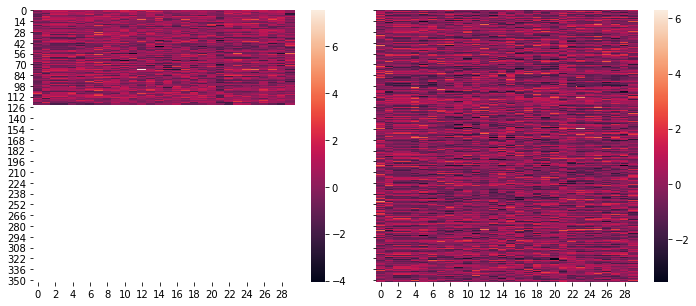

In [177]:
top_mi = np.argsort(-mi)[:max_nf]

mi_0 = X_train[y_train == 0][:,top_mi]
mi_1 = X_train[y_train == 1][:,top_mi]

fig, ax = plt.subplots(1, 2, figsize=(12,5), sharey = True) 
plt.subplots_adjust(wspace = 0.05)

sns.heatmap(mi_0, ax = ax[0])
sns.heatmap(mi_1, ax = ax[1])

plt.show()

In [178]:
# Using the best MI features from CV test
top_mi = np.argsort(-mi)[:max_nf]

X_train_mi = X_train[:,top_mi]
X_test_mi = X_test[:,top_mi]

In [179]:
rfc_mi = RandomForestClassifier(random_state = 12345, n_estimators = 100)
rfc_mi.fit(X_train_mi, y_train)


# Predictions
y_train_pred = rfc_mi.predict(X_train_mi) 
train_mat = sklearn.metrics.confusion_matrix(y_train, y_train_pred).ravel()

y_test_pred = rfc_mi.predict(X_test_mi)
test_mat = sklearn.metrics.confusion_matrix(y_test, y_test_pred).ravel()
(train_mat, test_mat)

(array([123,   0,   0, 353]), array([ 16,  51,   5, 132]))

### ANOVA

In [180]:
max_accuracy = 0
max_nf = 0
nf = 5

while nf <= 500:
    
    top_fi = np.argsort(-fi)[:nf]
    X_train_k = X_train[:,top_fi]
    
    rfc_k = RandomForestClassifier(random_state = 12345, n_estimators = 10)
    scores = cross_val_score(rfc_k, X_train_k, y_train, cv = 10, scoring = "accuracy")
    accuracy = np.mean(scores)
    
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        max_nf = nf
        print("# Features = {}, Mean CV Accuracy = {}".format(max_nf, max_accuracy))
        
    nf += 5  

# Features = 5, Mean CV Accuracy = 0.7376031263569258
# Features = 10, Mean CV Accuracy = 0.7519756838905776
# Features = 15, Mean CV Accuracy = 0.754363873208858
# Features = 30, Mean CV Accuracy = 0.7586191923577942
# Features = 60, Mean CV Accuracy = 0.7605731654363874
# Features = 155, Mean CV Accuracy = 0.7669561441597915
# Features = 285, Mean CV Accuracy = 0.7707772470690404


In [181]:
selector = SelectKBest(f_classif, k = max_nf)

X_train_fi = selector.fit_transform(X_train, y_train)
X_test_fi = selector.transform(X_test)

Visualize the optimally determined features using PCA to 2 dimensions:

In [182]:
k = 2

pca = PCA(n_components = k)
pca_fit = pca.fit_transform(X_train_fi)

pca_df = pd.DataFrame(data = pca_fit, columns = ['pc1', 'pc2'], index = train_df.index)
pca_df = pd.concat([train_df["cancer"], pca_df], axis = 1)

pca_var = pca.explained_variance_ratio_
print("Explained variance: {}".format(pca_var))

Explained variance: [0.41330876 0.08046454]


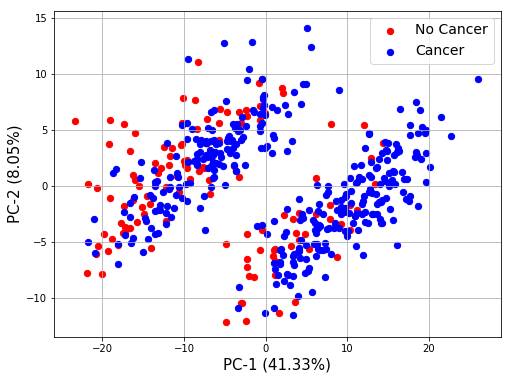

In [183]:
fig = plt.figure(figsize = (8,6))


ax = fig.add_subplot(1,1,1) 
ax.set_xlabel("PC-1 ({0:.2f}%)".format(pca_var[0]*100), fontsize = 15)
ax.set_ylabel("PC-2 ({0:.2f}%)".format(pca_var[1]*100), fontsize = 15)

colors = ['r', 'b']
targets = [0, 1]

for target, color in zip(targets,colors):
    idx = pca_df['cancer'] == target
    ax.scatter(pca_df.loc[idx, 'pc1'], pca_df.loc[idx, 'pc2'], c = color, s = 40)
ax.legend(["No Cancer", "Cancer"])
ax.grid()

# Model Tuning

In this section, we optimize hyperparameters for both an SVM and RF classifier, using the optimal feature subset determined from the above analysis.

In [40]:
# Pull Data
X_train = train_df.iloc[:,1:].values
y_train = train_df.iloc[:,0].values
X_test = test_df.iloc[:,1:].values
y_test = test_df.iloc[:,0].values

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [41]:
mi = mutual_info_classif(X_train, y_train)

In [42]:
anova = f_classif(X_train, y_train)
fi = anova[0]
pi = anova[1]

## SVM

MI: # features = 280

ANOVA: # features = 295

In [205]:
top_mi_svm = np.argsort(-mi)[:280]
top_fi_svm = np.argsort(-fi)[:295]

X_train_fi = X_train[:,top_fi_svm]
X_test_fi = X_train[:,top_fi_svm]

## Random Forest

MI: # features = 50

ANOVA: # features = 195

In [68]:
top_mi_rf = np.argsort(-mi)[:145]
top_fi_rf = np.argsort(-fi)[:195]

X_train_mi = X_train[:,top_mi_rf]
X_test_mi = X_test[:,top_mi_rf]

X_train_fi = X_train[:,top_fi_rf]
X_test_fi = X_test[:,top_fi_rf]

### PCA Reduction

In [73]:
var = 0
k = 1

while var < 0.95:
    pca = PCA(n_components = k)
    pca_fit = pca.fit_transform(X_train_fi)
    var = np.sum(pca.explained_variance_ratio_)
    
    print("Variance explained by k = {}: {}".format(k, var))
    
    k+=5

Variance explained by k = 1: 0.6365124720524487
Variance explained by k = 6: 0.7774930769090241
Variance explained by k = 11: 0.828733410910381
Variance explained by k = 16: 0.8619454252326713
Variance explained by k = 21: 0.8868559973626308
Variance explained by k = 26: 0.9059742819223962
Variance explained by k = 31: 0.9217038621067608
Variance explained by k = 36: 0.9351640180805458
Variance explained by k = 41: 0.9462794537453055
Variance explained by k = 46: 0.955483616410861


In [74]:
k = 46
pca_train = PCA(n_components = k)

X_train_pca = pca_train.fit_transform(X_train_fi)
X_test_pca = pca_train.transform(X_test_fi)

print("Explained variance: {}".format(np.sum(pca_train.explained_variance_ratio_)))

Explained variance: 0.955483616410861


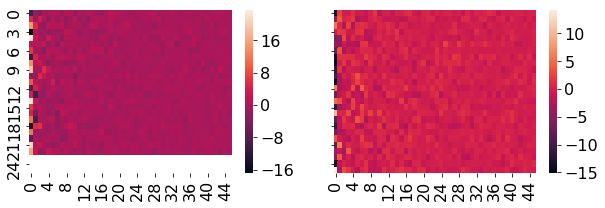

In [91]:
# Heatmap plot of the PCA transformed features

pca_df = pd.DataFrame(data = X_test_pca, index = test_df.index)
pca_df = pd.concat([test_df["cancer"], pca_df], axis = 1)

pca0 = pca_df[pca_df["cancer"] == 0].values[:,1:]
pca1 = pca_df[pca_df["cancer"] == 1].values[:,1:]

fig, ax = plt.subplots(1, 2, figsize=(10,3), sharey = True) 

sns.heatmap(pca0, ax = ax[0])
sns.heatmap(pca1, ax = ax[1])

plt.show()

### Hyperparameter Tuning

In [105]:
rfc = RandomForestClassifier(random_state = 12345, n_estimators = 100)
rfc.fit(X_train_pca, y_train)

# Predictions
y_train_pred = rfc.predict(X_train_pca) 
train_mat = sklearn.metrics.confusion_matrix(y_train, y_train_pred).ravel()

y_test_pred = rfc.predict(X_test_pca)
test_mat = sklearn.metrics.confusion_matrix(y_test, y_test_pred).ravel()
(train_mat, test_mat)

(array([62,  0,  0, 52]), array([17,  6, 12, 14]))

In [107]:
train_df["1405_i_at"]

geoid
GSM94115    6.915914
GSM94085    5.526152
GSM94027    5.856583
GSM94033    5.061891
GSM94126    5.663914
GSM98771    6.113800
GSM94144    6.412534
GSM94049    5.070067
GSM94147    5.922308
GSM98795    5.569574
GSM94155    7.693203
GSM94148    6.337440
GSM94029    6.886696
GSM98790    5.258369
GSM94088    6.305235
GSM94095    5.239321
GSM94105    6.254816
GSM94102    4.555859
GSM94138    5.069088
GSM94078    6.463300
GSM94108    6.572043
GSM98772    5.521792
GSM94100    5.415214
GSM94130    5.879945
GSM94140    6.231829
GSM94121    5.438502
GSM94170    5.142199
GSM94067    4.772267
GSM94083    6.547511
GSM94101    5.833621
              ...   
GSM98770    5.648945
GSM94099    6.504416
GSM94065    5.230698
GSM94124    5.908830
GSM98789    7.763766
GSM94135    4.731450
GSM94056    5.754313
GSM98796    7.880456
GSM94047    5.916263
GSM94075    6.493164
GSM94026    6.419746
GSM94118    6.472413
GSM98777    6.432668
GSM94114    5.998044
GSM94031    5.132868
GSM94161    6.116989
GSM9879